# Entraînement d'un réseau de neurones pour jouer au Go

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/Deep-learning/blob/main/Projet/ResGo2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Description

- [https://www.lamsade.dauphine.fr/~cazenave/DeepLearningProject.html](https://www.lamsade.dauphine.fr/~cazenave/DeepLearningProject.html)  
- L'objectif est d'entraîner un réseau pour jouer au jeu de Go.  
- Afin de garantir une équité en termes de ressources d'entraînement, le nombre de paramètres des réseaux soumis doit être inférieur à 100 000.  
- Le nombre maximal d'étudiants par équipe est de deux.  
- Les données utilisées pour l'entraînement proviennent des parties auto-jouées du programme Katago Go.  
- Le jeu de données d'entraînement contient un total de 1 000 000 de parties différentes.  
- Les données d'entrée sont composées de 31 plans de taille 19x19 :  
  - Couleur au trait  
  - Échelles  
  - État actuel sur deux plans  
  - Deux états précédents sur plusieurs plans  
- Les cibles de sortie sont :  
  - **La politique** : un vecteur de taille 361 avec `1.0` pour le coup joué, `0.0` pour les autres coups.  
  - **La valeur** : une valeur entre `0.0` et `1.0` fournie par la recherche d'arbre Monte-Carlo, représentant la probabilité de victoire de Blanc.

- Le projet a été écrit et fonctionne sous Ubuntu 22.04.  
- Il utilise TensorFlow 2.9 et Keras pour le réseau.  
- Un exemple de réseau convolutionnel avec deux têtes est donné dans le fichier `golois.py` et est sauvegardé dans le fichier `test.h5`.  
- Les réseaux que vous concevez et entraînez doivent également avoir les mêmes têtes de politique et de valeur et être sauvegardés au format `.h5`.  
- Un exemple de réseau et un épisode d'entraînement sont fournis dans le fichier `golois.py`.  
- Si vous souhaitez compiler la bibliothèque Golois, vous devez installer **Pybind11** et exécuter `compile.sh`.

## Tournois

- Toutes les deux semaines environ, j'organiserai un tournoi entre les réseaux que vous téléchargez.  
- Chaque nom de réseau correspond aux noms des étudiants qui ont conçu et entraîné le réseau.  
- Le modèle doit être sauvegardé au format **Keras h5**.  
- Un tournoi en **round robin** sera organisé et les résultats seront envoyés par e-mail.  
- Chaque réseau sera utilisé par un moteur **PUCT**, qui disposera de **2 secondes de temps CPU** par coup pour jouer dans le tournoi.

## Exemple de réseau

```python
planes = 31
moves = 361
N = 10000
epochs = 20
batch = 128
filters = 32
input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')
policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)
value = np.random.randint(2, size=(N,))
value = value.astype ('float32')
end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')
groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

input = keras.Input(shape=(19, 19, planes), name='board')
x = layers.Conv2D(filters, 1, activation='relu', padding='same')(input)
for i in range (5):
  x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
policy_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
policy_head = layers.Flatten()(policy_head)
policy_head = layers.Activation('softmax', name='policy')(policy_head)
value_head = layers.Conv2D(1, 1, activation='relu', padding='same', use_bias = False, kernel_regularizer=regularizers.l2(0.0001))(x)
value_head = layers.Flatten()(value_head)
value_head = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(value_head)
value_head = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(value_head)
model = keras.Model(inputs=input, outputs=[policy_head, value_head])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
loss={'policy': 'categorical_crossentropy', 'value': 'binary_crossentropy'},
loss_weights={'policy' : 1.0, 'value' : 1.0},
metrics={'policy': 'categorical_accuracy', 'value': 'mse'})
for i in range (1, epochs + 1):
  print ('epoch ' + str (i))
  golois.getBatch (input_data, policy, value, end, groups, i * N)
  history = model.fit(input_data,
  {'policy': policy, 'value': value},
  epochs=1, batch_size=batch)
  if (i % 5 == 0):
  gc.collect ()
  if (i % 20 == 0):
  golois.getValidation (input_data, policy, value, end)
  val = model.evaluate (input_data,
  [policy, value], verbose = 0, batch_size=batch)
  print ("val =", val)
  model.save ('test.h5')
```

## Instructions :  
- Entraînez un réseau pour jouer au Go.  
- Soumettez les réseaux entraînés **avant samedi soir**.  
- Tournoi des réseaux **chaque dimanche**.  
- Téléchargez un réseau **avant la fin de la session**.

In [19]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2025.zip
!unzip project2025.zip
!ls -l

--2025-03-12 21:30:58--  https://www.lamsade.dauphine.fr/~cazenave/project2025.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 486727746 (464M) [application/zip]
Saving to: ‘project2025.zip.1’

project2025.zip.1   100%[===================>] 464.18M  71.9MB/s    in 9.7s    

2025-03-12 21:31:08 (47.8 MB/s) - ‘project2025.zip.1’ saved [486727746/486727746]

Archive:  project2025.zip
replace games2022.data? [y]es, [n]o, [A]ll, [N]one, [r]ename: total 2858012
-rw-r--r-- 1 root root 1950168720 Feb 23  2023 games2022.data
-rwxr-xr-x 1 root root     234952 Jan 24  2024 golois.cpython-310-x86_64-linux-gnu.so
-rwxr-xr-x 1 root root     692584 Jan 24  2024 Golois.cpython-310-x86_64-linux-gnu.so
-rwxr-xr-x 1 root root     239144 Jul 19  2023 golois.cpython-311-x86_64-linux-gnu.so
-rwxr-xr-x 1 root root     236328 O

In [20]:
!pip install tensorrt-bindings==8.6.1
!pip install --extra-index-url https://pypi.nvidia.com tensorrt-libs
!pip install tensorflow[and-cuda]==2.15.0

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [21]:
from abc import ABC, abstractmethod
from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import gc
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras


import golois


class GONet(ABC):

    def __init__(
        self, batch=128, epochs=20, filters=32, moves=361, N=10000, planes=31
    ):
        self.batch = batch
        self.epochs = epochs
        self.filters = filters
        self.moves = moves
        self.N = N
        self.planes = planes
        self.set_input_data(N, planes)
        self.set_policy(N, moves)
        self.set_value(N)
        self.set_end(N)
        self.set_groups(N)
        print("Tensorflow version", tf.__version__)
        print("getValidation", flush=True)
        golois.getValidation(
            self.input_data, self.policy, self.value, self.end
        )
        self.loss_total = []
        self.policy_loss  = []
        self.value_loss  = []
        self.policy_acc = []
        self.value_mse = []

    def set_input_data(self, N, planes):
        input_data = np.random.randint(2, size=(N, 19, 19, planes))
        self.input_data = input_data.astype("float32")

    def get_input_data(self):
        return self.input_data

    def set_policy(self, N, moves):
        policy = np.random.randint(moves, size=(N,))
        self.policy = keras.utils.to_categorical(policy)

    def get_policy(self):
        return self.policy

    def set_value(self, N):
        value = np.random.randint(2, size=(N,))
        self.value = value.astype("float32")

    def get_value(self):
        return self.value

    def set_end(self, N):
        end = np.random.randint(2, size=(N, 19, 19, 2))
        self.end = end.astype("float32")

    def get_end(self):
        return self.end

    def set_groups(self, N):
        groups = np.zeros((N, 19, 19, 1))
        self.groups = groups.astype("float32")

    def get_groups(self):
        return self.groups

    @abstractmethod
    def set_model(self):
        pass

    def train_model(self, epochs):
        for i in range(1, epochs + 1):
            print(f"epoch {str(i)}")
            golois.getBatch(
                self.input_data,
                self.policy,
                self.value,
                self.end,
                self.groups,
                i * self.N,
            )
            history = self.model.fit(
                self.input_data,
                {"policy": self.policy, "value": self.value},
                epochs=1,
                batch_size=self.batch,
            )
            # Extraction des valeurs depuis history.history
            self.loss_total.append(history.history["loss"][0])  # Loss globale
            self.policy_loss.append(history.history["policy_loss"][0])  # Policy loss
            self.value_loss.append(history.history["value_loss"][0])  # Value loss
            self.policy_acc.append(history.history["policy_categorical_accuracy"][0])  # Policy accuracy
            self.value_mse.append(history.history["value_mse"][0])  # Value MSE
            if i % 5 == 0:
                gc.collect()
            if i % 20 == 0:
                golois.getValidation(
                    self.input_data, self.policy, self.value, self.end
                )
                val = self.model.evaluate(
                    self.input_data,
                    [self.policy, self.value],
                    verbose=0,
                    batch_size=self.batch,
                )
                print(f"{val=}")

    def save_model(self, name):
        self.model.save(name)
        files.download(name)

    def plot_training_history(self):
        """Trace les courbes des pertes et métriques en fonction des époques."""
        epochs = range(1, len(self.loss_total) + 1)  # Liste des époques

        plt.figure(figsize=(12, 6))

        # Graphique des pertes
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.loss_total, label="Loss totale", marker="o")
        plt.plot(epochs, self.policy_loss, label="Policy Loss", marker="o")
        plt.plot(epochs, self.value_loss, label="Value Loss", marker="o")
        plt.xlabel("Époques")
        plt.ylabel("Valeur de la perte")
        plt.title("Évolution des pertes")
        plt.legend()
        plt.grid(True)

        # Graphique des métriques
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.policy_acc, label="Policy Accuracy", marker="o")
        plt.plot(epochs, self.value_mse, label="Value MSE", marker="o")
        plt.xlabel("Époques")
        plt.ylabel("Valeur des métriques")
        plt.title("Évolution des métriques")
        plt.legend()
        plt.grid(True)

        # Affichage
        plt.tight_layout()
        plt.show()

In [22]:
class GONetDemo(GONet):

    def __init__(
        self, batch=128, epochs=20, filters=32, moves=361, N=10000, planes=31
    ):
        super().__init__(batch, epochs, filters, moves, N, planes)

    def set_model(self):
        input_ = keras.Input(shape=(19, 19, self.planes), name="board")
        x = layers.Conv2D(self.filters, 1, activation="relu", padding="same")(
            input_
        )
        for _ in range(5):
            x = layers.Conv2D(
                self.filters, 3, activation="relu", padding="same"
            )(x)
        policy_head = layers.Conv2D(
            1,
            1,
            activation="relu",
            padding="same",
            use_bias=False,
            kernel_regularizer=regularizers.l2(0.0001),
        )(x)
        policy_head = layers.Flatten()(policy_head)
        policy_head = layers.Activation("softmax", name="policy")(policy_head)
        value_head = layers.Conv2D(
            1,
            1,
            activation="relu",
            padding="same",
            use_bias=False,
            kernel_regularizer=regularizers.l2(0.0001),
        )(x)
        value_head = layers.Flatten()(value_head)
        value_head = layers.Dense(
            50, activation="relu", kernel_regularizer=regularizers.l2(0.0001)
        )(value_head)
        value_head = layers.Dense(
            1,
            activation="sigmoid",
            name="value",
            kernel_regularizer=regularizers.l2(0.0001),
        )(value_head)

        model = keras.Model(inputs=input_, outputs=[policy_head, value_head])

        model.summary()

        model.compile(
            optimizer=keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
            loss={
                "policy": "categorical_crossentropy",
                "value": "binary_crossentropy",
            },
            loss_weights={"policy": 1.0, "value": 1.0},
            metrics={"policy": "categorical_accuracy", "value": "mse"},
        )

        self.model = model

Tensorflow version 2.15.0
getValidation
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_64 (Conv2D)          (None, 19, 19, 32)           1024      ['board[0][0]']               
                                                                                                  
 conv2d_65 (Conv2D)          (None, 19, 19, 32)           9248      ['conv2d_64[0][0]']           
                                                                                                  
 conv2d_66 (Conv2D)          (None, 19, 19, 32)           9248      ['conv2d_65[0][0]']           
                                                    

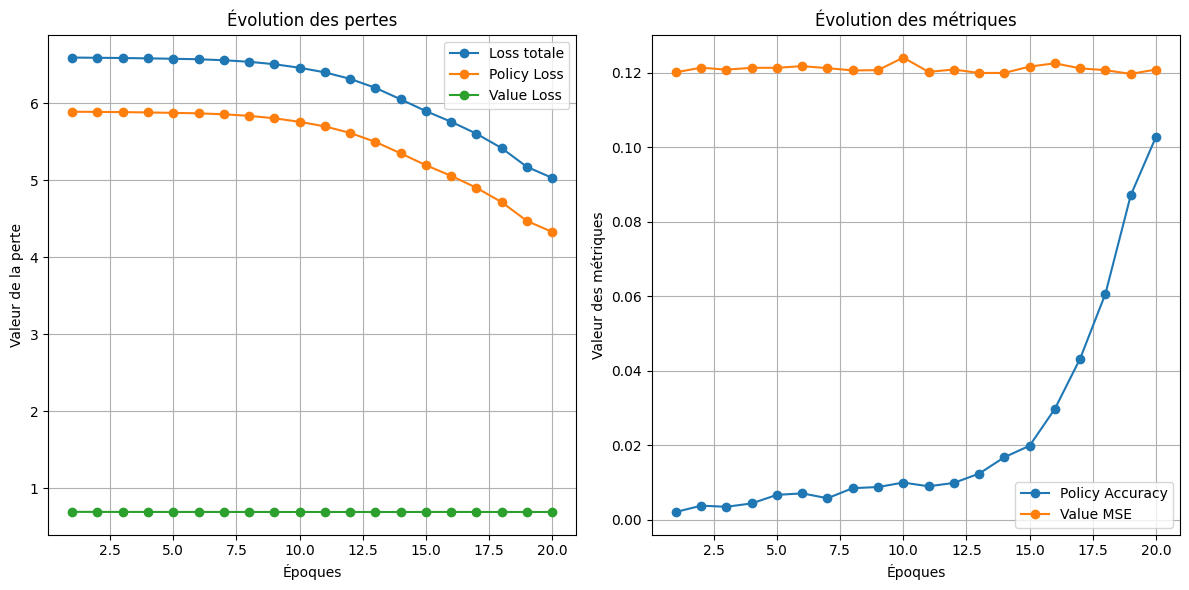

In [23]:
GONetDemo_instance = GONetDemo()
GONetDemo_instance.set_model()
GONetDemo_instance.train_model(20)
GONetDemo_instance.plot_training_history()
# GONet_instance.save_model("test.h5")

In [24]:
class GONetResidual(GONet):

    def __init__(
        self, batch=128, epochs=20, filters=32, moves=361, N=10000, planes=31
    ):
        super().__init__(batch, epochs, filters, moves, N, planes)

    # Residual Block Function
    def residual_block(self, x, filters):
        """A ResNet-style residual block with skip connection."""
        shortcut = x  # Save input for shortcut connection

        x = layers.Conv2D(
            filters,
            (3, 3),
            padding="same",
            use_bias=False,
            kernel_regularizer=regularizers.l2(0.0001),
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, shortcut])  # Add residual connection
        x = layers.ReLU()(x)

        return x

    def set_model(self):
        input_layer = layers.Input(shape=(19, 19, self.planes), name="board")
        # Initial Conv Layer
        x = layers.Conv2D(
            self.filters,
            (3, 3),
            padding="same",
            activation="relu",
            kernel_regularizer=regularizers.l2(0.0001),
        )(input_layer)
        # Apply 2 Residual Blocks
        for _ in range(2):
            x = self.residual_block(x, self.filters)

        # Policy Head (Move Probabilities)
        policy_head = layers.Conv2D(
            2,
            (1, 1),
            activation="relu",
            padding="same",
            use_bias=False,
            kernel_regularizer=regularizers.l2(0.0001),
        )(x)
        policy_head = layers.Flatten()(policy_head)
        policy_head = layers.Dense(
            361,
            activation="softmax",
            name="policy",
            kernel_regularizer=regularizers.l2(0.0001),
        )(policy_head)

        # Value Head (Win Probability)
        value_head = layers.Conv2D(
            1,
            (1, 1),
            activation="relu",
            padding="same",
            use_bias=False,
            kernel_regularizer=regularizers.l2(0.0001),
        )(x)
        value_head = layers.Flatten()(value_head)
        value_head = layers.Dense(
            50, activation="relu", kernel_regularizer=regularizers.l2(0.0001)
        )(value_head)
        value_head = layers.Dense(
            1,
            activation="sigmoid",
            name="value",
            kernel_regularizer=regularizers.l2(0.0001),
        )(value_head)

        # Create Model
        model = keras.Model(
            inputs=input_layer, outputs=[policy_head, value_head]
        )
        model.summary()

        model.compile(
            optimizer=keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
            loss={
                "policy": "categorical_crossentropy",
                "value": "binary_crossentropy",
            },
            loss_weights={"policy": 1.0, "value": 1.0},
            metrics={"policy": "categorical_accuracy", "value": "mse"},
        )
        self.model = model

Tensorflow version 2.15.0
getValidation
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 board (InputLayer)          [(None, 19, 19, 31)]         0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 19, 19, 32)           8960      ['board[0][0]']               
                                                                                                  
 conv2d_73 (Conv2D)          (None, 19, 19, 32)           9216      ['conv2d_72[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 19, 19, 32)           128       ['conv2d_73[0][0]']           
 Normalization)                                     

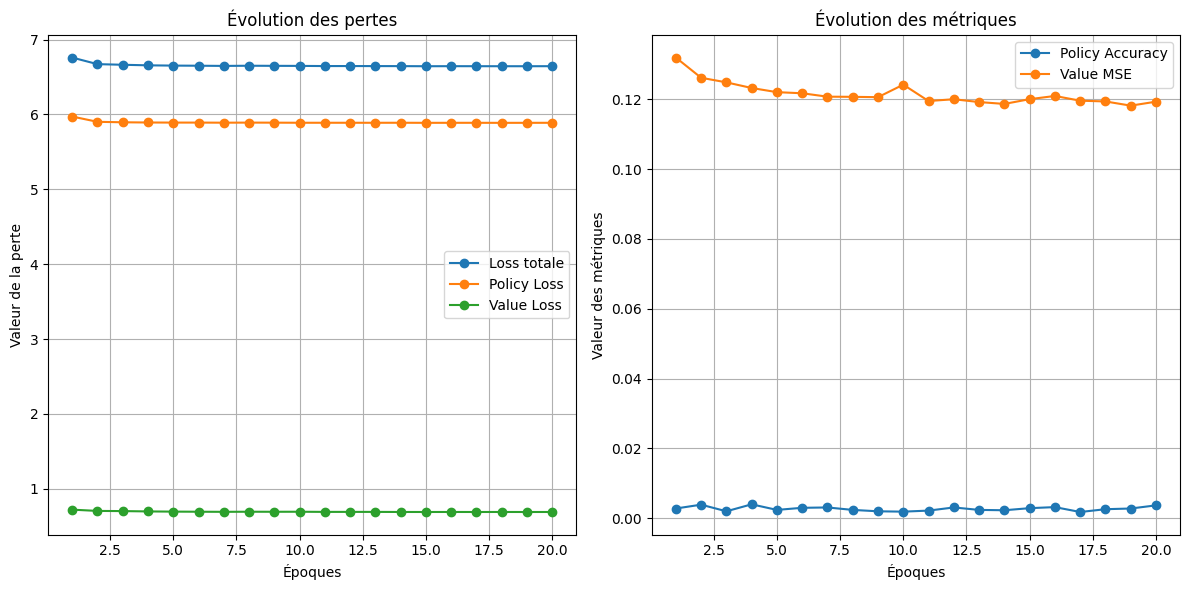

In [25]:
GONetResidual_instance = GONetResidual()
GONetResidual_instance.set_model()
GONetResidual_instance.train_model(20)
GONetResidual_instance.plot_training_history()
# GONetResidual_instance.save_model("test.h5")